In [2]:
# Import libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [5]:
# Configure API key 

quandl.ApiConfig.api_key = 'CHazwTxXaSr1xr4LSx4a'

In [6]:
# Importing the US Federal Reserve Data Releases "Interest rates and price indexes; 3-month Treasury yield, Quarterly" variable.

data = quandl.get('FED/FL073161133_Q')

In [7]:
data.head(5)

,Value
Date,
1954-03-31,1060.0
1954-06-30,790.0
1954-09-30,883.0
1954-12-31,1028.0
1955-03-31,1230.0


In [8]:
data.shape

(273, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

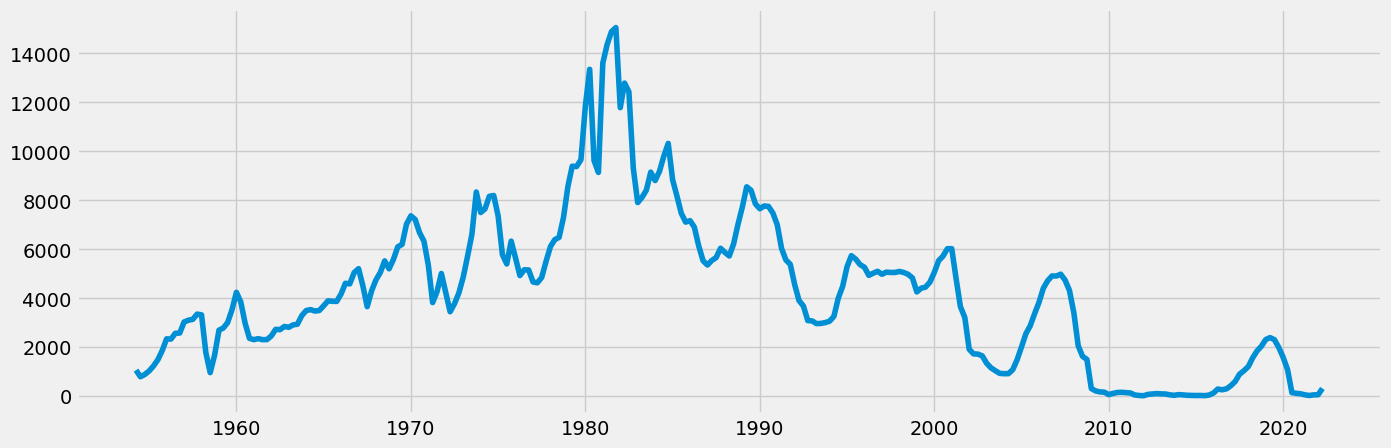

In [11]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### Subsetting, wrangling, and cleaning time-series data

In [12]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [13]:
data_2.head()

,Date,Value
0,1954-03-31,1060.0
1,1954-06-30,790.0
2,1954-09-30,883.0
3,1954-12-31,1028.0
4,1955-03-31,1230.0


In [14]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-03-31') & (data_2['Date'] < '2022-03-31')]

In [15]:
data_sub.shape

(168, 2)

In [16]:
data_sub.head()

,Date,Value
104,1980-03-31,13346.0
105,1980-06-30,9618.0
106,1980-09-30,9135.0
107,1980-12-31,13605.0
108,1981-03-31,14353.0


In [17]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-03-31,13346.0
1980-06-30,9618.0
1980-09-30,9135.0
1980-12-31,13605.0
1981-03-31,14353.0


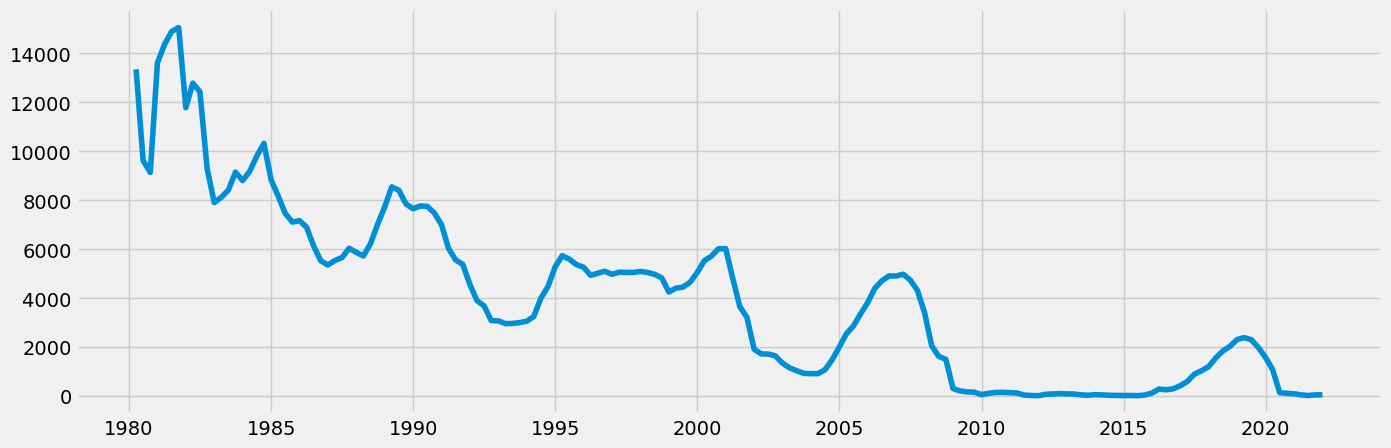

In [18]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [19]:
# Check for missing values (shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [24]:
# Check for duplicates

dups = data_sub[data_sub.duplicated()]

dups.head(30)


,Value
datetime,
1997-09-30,5049.0
1998-06-30,4974.0
2004-03-31,916.0
2013-12-31,60.0
2015-03-31,25.0
2021-06-30,25.0


### Actually no dups in the dataframe.

### Time-series analysis: decomposition

In [25]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [26]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

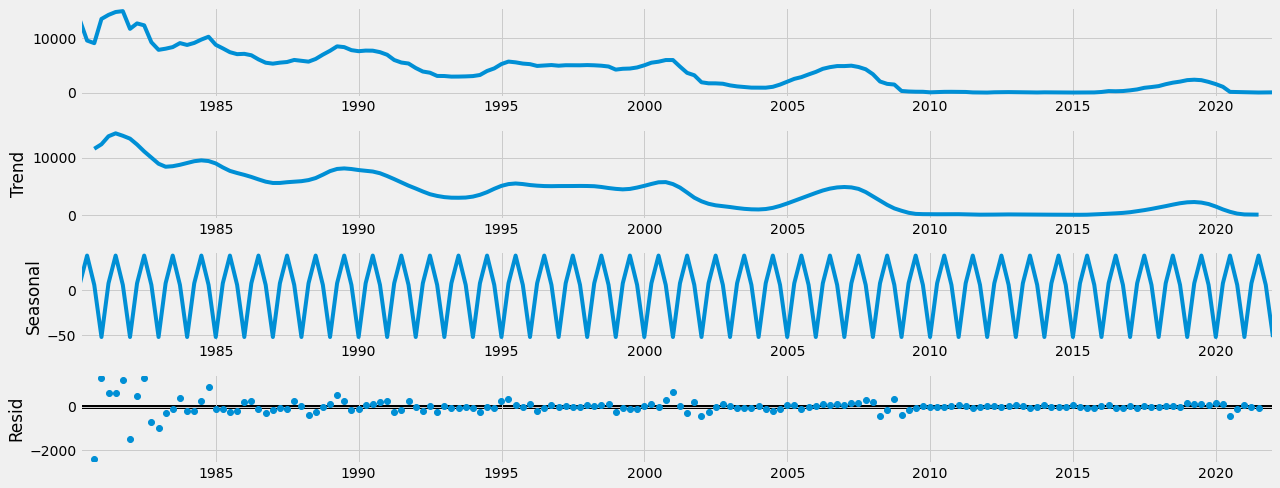

In [27]:
# Plot the separate components

decomposition.plot()
plt.show()

### Testing for stationarity

In [29]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.296300
p-value                          0.173164
Number of Lags Used             13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


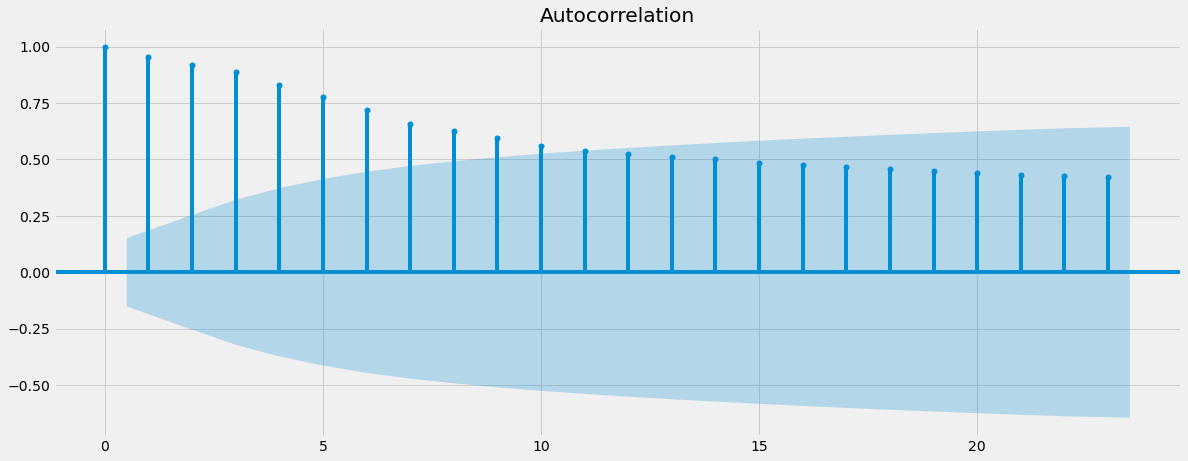

In [30]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

###  Stationarizing the Federal Reserve Economic Data

In [31]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [32]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [33]:
data_diff.head()

,Value
datetime,
1980-06-30,-3728.0
1980-09-30,-483.0
1980-12-31,4470.0
1981-03-31,748.0
1981-06-30,532.0


In [34]:
data_diff.columns

Index(['Value'], dtype='object')

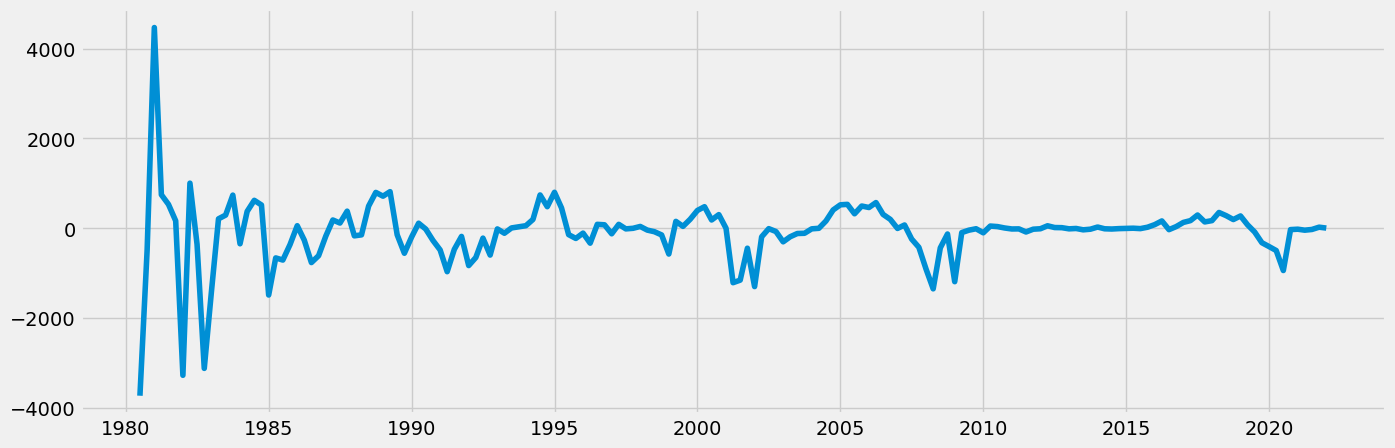

In [35]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [36]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -5.354305
p-value                          0.000004
Number of Lags Used             14.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


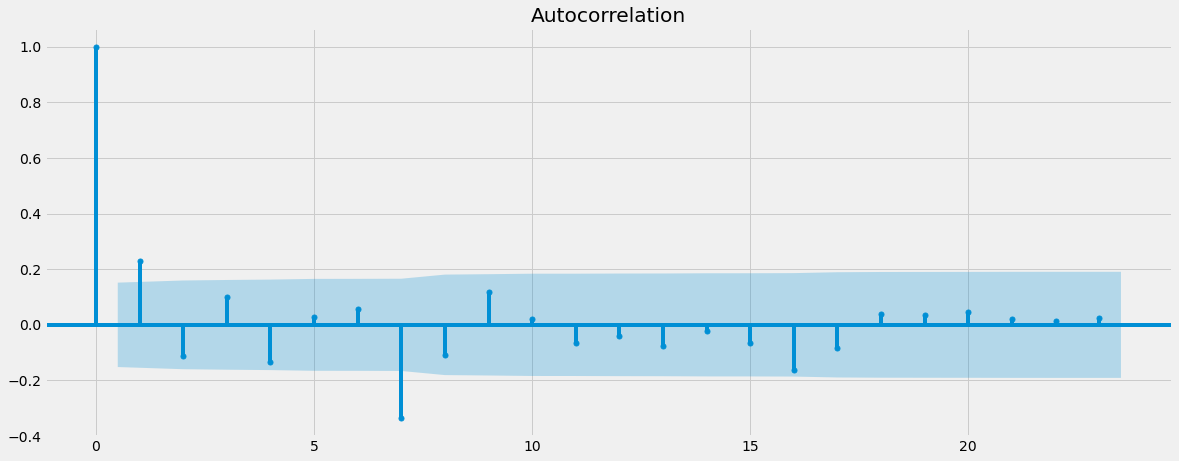

In [37]:
plot_acf(data_diff)
plt.show()